In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,Dense,MaxPool2D 
from tensorflow.keras.utils import to_categorical
import os
import cv2

In [38]:
BATCH_SIZE = 68
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=12

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(68, 256, 256, 3)
[0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1
 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1]


# Visualize some of the images from our dataset

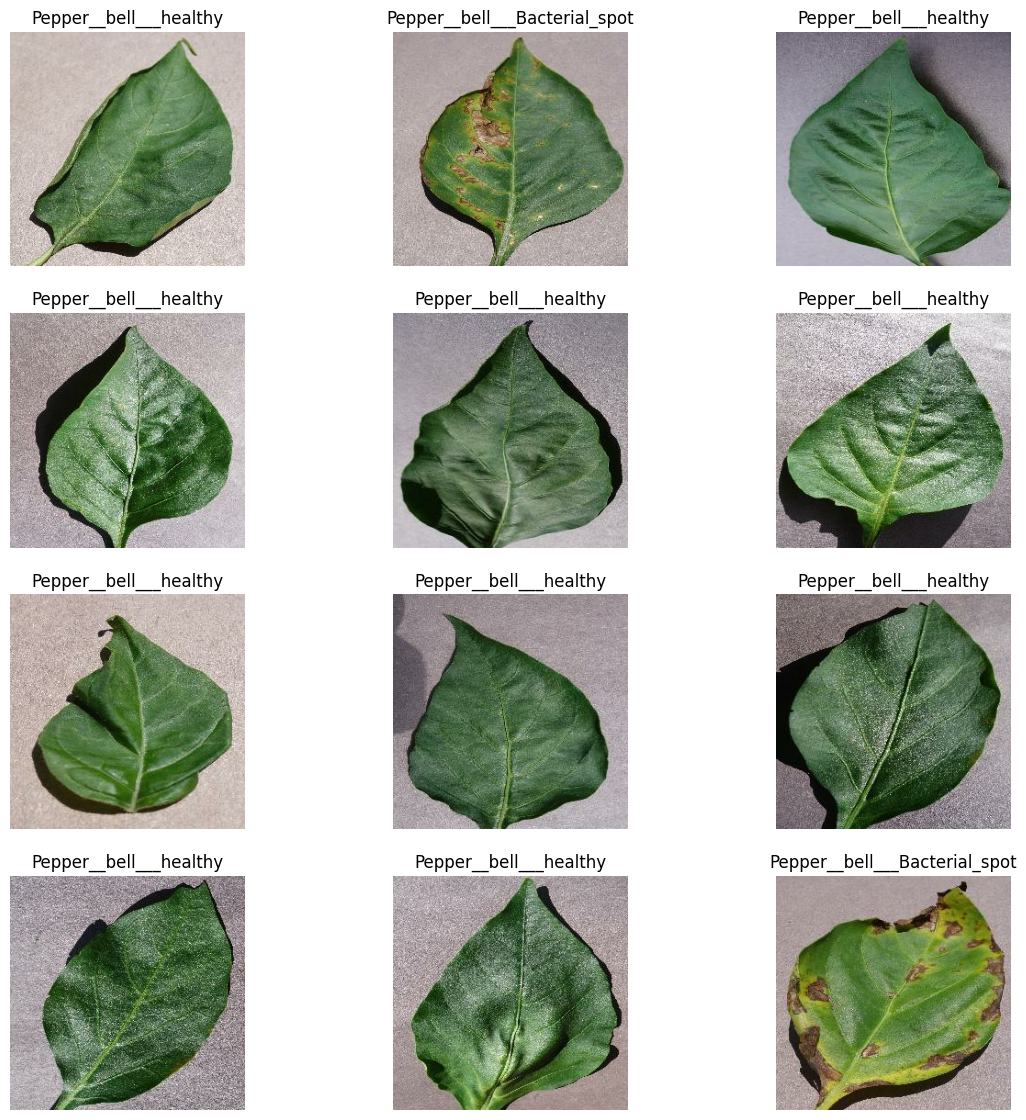

In [6]:
plt.figure(figsize=(14, 14))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential()
model.add(Conv2D(32, kernel_size =3, activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2,2))),
model.add(Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2))),
model.add(Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2))),
model.add(Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dense(n_classes,activation='softmax'))

C:\Users\HP\anaconda3\envs\py310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,682 (717.51 KB)

 Trainable params: 183,682 (717.51 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=12,
)

Epoch 1/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 461s 11s/step - accuracy: 0.5591 - loss: 11.4560 - val_accuracy: 0.7255 - val_loss: 0.5568
Epoch 2/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 188s 6s/step - accuracy: 0.6659 - loss: 0.6254 - val_accuracy: 0.6765 - val_loss: 0.6154
Epoch 3/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 124s 4s/step - accuracy: 0.7678 - loss: 0.5007 - val_accuracy: 0.6520 - val_loss: 0.6198
Epoch 4/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.8168 - loss: 0.4229 - val_accuracy: 0.3627 - val_loss: 0.7377
Epoch 5/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.6643 - loss: 0.6147 - val_accuracy: 0.8529 - val_loss: 0.3519
Epoch 6/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.7268 - loss: 0.5538 - val_accuracy: 0.7353 - val_loss: 0.5359
Epoch 7/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.8800 - loss: 0.2952 - val_accuracy: 0.9069 - val_loss: 0.2516
Epoch 8/12
29/29 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.9358 - loss: 0.2067 - val_accuracy: 0.7255 - 

In [28]:
scores = model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9623 - loss: 0.0804


In [29]:
scores

[0.08293510973453522, 0.9617646932601929]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 12, 'steps': 29}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

12

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[4.474126815795898,
 0.595323383808136,
 0.5217022895812988,
 0.44521161913871765,
 0.5444651246070862]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

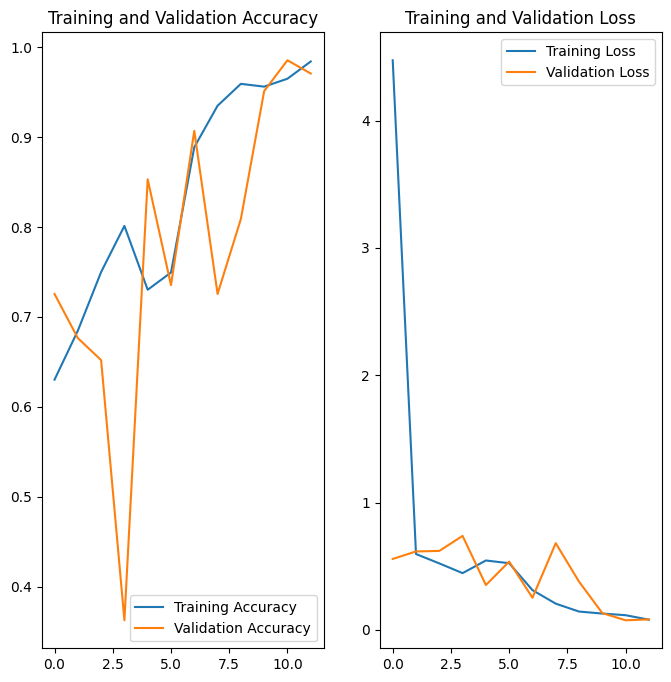

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Run prediction on a sample image

first image to predict
actual label: Pepper__bell___Bacterial_spot
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 692ms/step
predicted label: Pepper__bell___Bacterial_spot


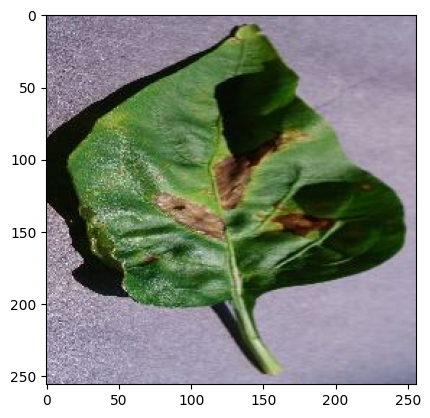

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


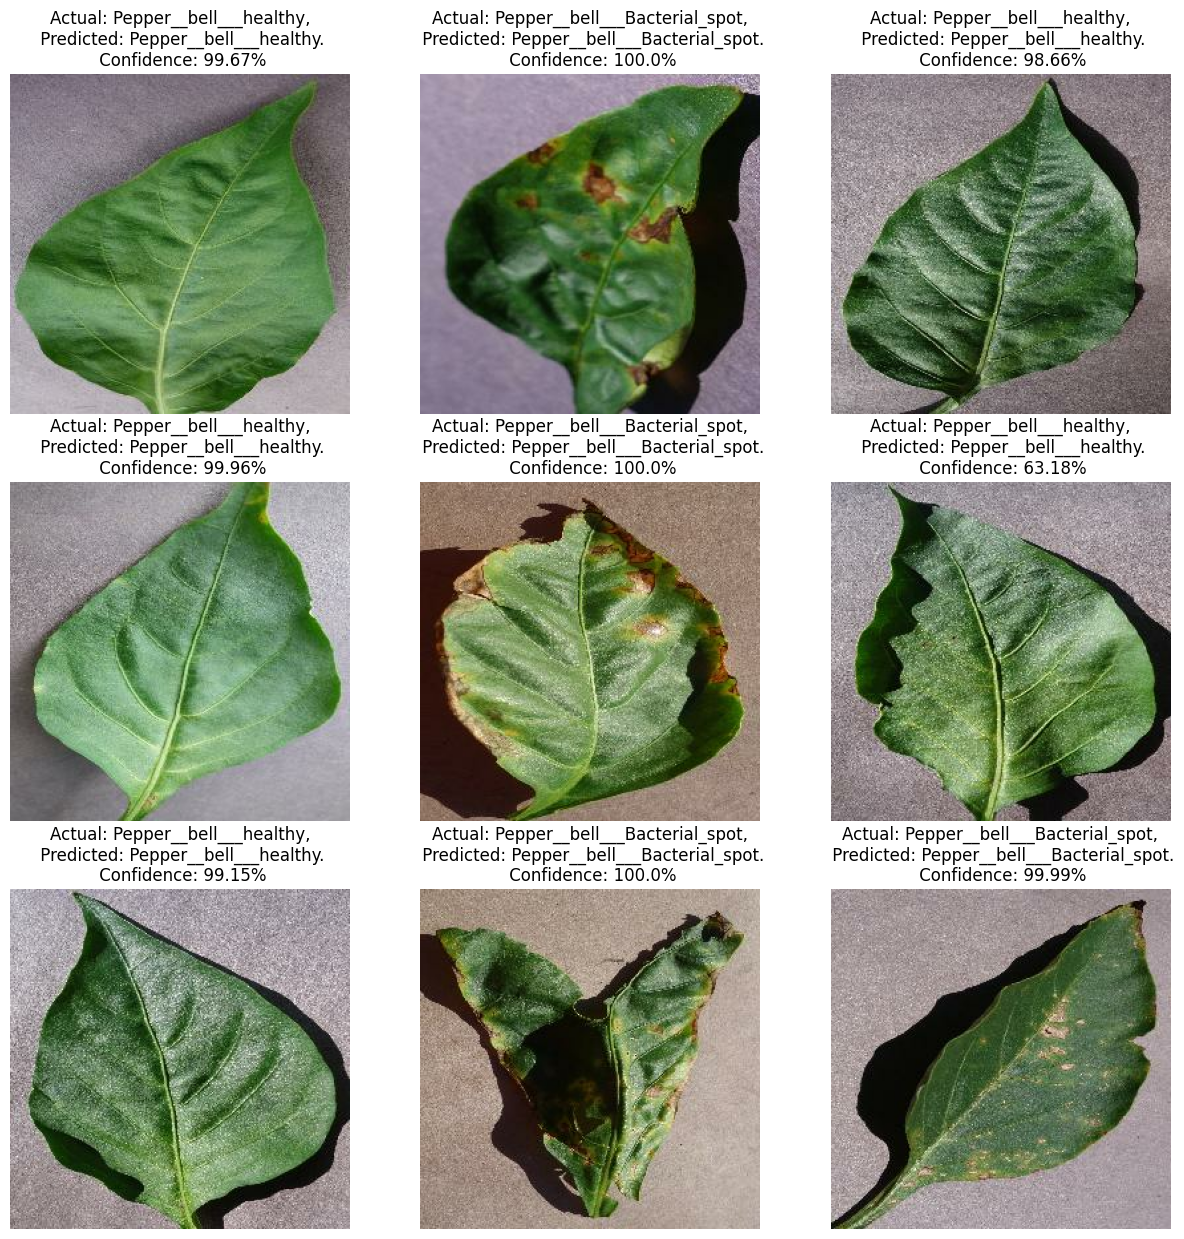

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [49]:
model_version=1
model.save(f"../models/{model_version}.keras")

In [51]:
model.save("../bellpaper.h5")